# Рекомендация тарифов

В вашем распоряжении данные о поведении клиентов, которые уже перешли на эти тарифы (из проекта курса «Статистический анализ данных»). Нужно построить модель для задачи классификации, которая выберет подходящий тариф. Предобработка данных не понадобится — вы её уже сделали.

Постройте модель с максимально большим значением *accuracy*. Чтобы сдать проект успешно, нужно довести долю правильных ответов по крайней мере до 0.75. Проверьте *accuracy* на тестовой выборке самостоятельно.

## Откройте и изучите файл

Импортируем необходимые для проекта библиотеки:

In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

In [ ]:
import warnings
warnings.simplefilter('ignore')

Импортируем датасет в проект:

In [ ]:
data = pd.read_csv('/datasets/users_behavior.csv')
data.head()

,calls,minutes,messages,mb_used,is_ultra
0,40.0,311.90,83.0,19915.42,0
1,85.0,516.75,56.0,22696.96,0
2,77.0,467.66,86.0,21060.45,0
3,106.0,745.53,81.0,8437.39,1
4,66.0,418.74,1.0,14502.75,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3214 entries, 0 to 3213
Data columns (total 5 columns):
calls       3214 non-null float64
minutes     3214 non-null float64
messages    3214 non-null float64
mb_used     3214 non-null float64
is_ultra    3214 non-null int64
dtypes: float64(4), int64(1)
memory usage: 125.7 KB


**Вывод**

Импортировали необходимые для создания классификации библиотеки и импортировали сами данные. В таблице есть 5 столбцов характеризующие активность пользователей и тот тариф, который пользователь выбрал. Нам необходимо создать модель, способную предсказывать другим пользователям нужный тариф.

Из данных видно, что есть 2 столбца, которые характеризуют один и тот же параметр(calls и minutes). Необходимо будет проверить данные на мультиколлинеарность.

Предварительно можно утверждать, что данных достаточно для создания хорошей и вменяемой модели.

## Разбейте данные на выборки

Поскольку тестовая выборка от нас не спрятана, то будем делить данные на 3 части - обучающую, валидационную и тестовую выборки в соотношении 60-20-20.

In [ ]:
features = data.drop('is_ultra', axis=1)
target = data['is_ultra']

Разделим сначала на общую часть (train и valid) и test:

In [ ]:
features_main, features_test, target_main, target_test = train_test_split(features, target, test_size=0.2, random_state=27)

In [ ]:
features_train, features_valid, target_train, target_valid = train_test_split(features_main, target_main, test_size=0.25, random_state=27)

In [ ]:
display(features_train.shape)
display(target_train.shape)
display(features_valid.shape)
display(target_valid.shape)
display(features_test.shape)
display(target_test.shape)

(1928, 4)

(1928,)

(643, 4)

(643,)

(643, 4)

(643,)

**Вывод**

Поскольку изначально мы знали что отдельных тестовых данных нет, то необходимо было разделить датасет на 3 части - обучающую, валидационную и тестовую выборки в соотношении 60-20-20. Функция train_test_split делит данные лишь на 2 части и чтобы разделить датасет надо сначало выполнить деление 80/20, а далее 75/25. Таким образом мы получили 3 части 60%, 20%, 20%. Данные готовы к обучению.

## Исследуйте модели

В нашем проекте нам необходимо предсказать тариф пользователю из существующих. Это задача классификации, причем поскольку тарифов 2, то эта задача бинарной классификации. Для нее подойдут такие модели как: решающее дерево, случайный лес и логистическая регрессия. Создадим модели и поварьируем их гиперпараметры, чтобы выбрать лучшую. Качество модели будем определять по метрике accuracy, для задачи бинарной классификации она подходит лучше всего. 

### Предварительная проверка на мультиколлинеарность

'Матрица диаграмм рассеяния'

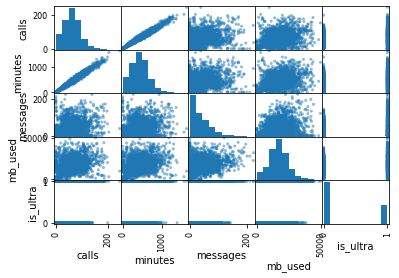

In [ ]:
display('Матрица диаграмм рассеяния')
pd.plotting.scatter_matrix(data)
plt.show()

In [ ]:
data.corr()

,calls,minutes,messages,mb_used,is_ultra
calls,1.000000,0.982083,0.177385,0.286442,0.207122
minutes,0.982083,1.000000,0.173110,0.280967,0.206955
messages,0.177385,0.173110,1.000000,0.195721,0.203830
mb_used,0.286442,0.280967,0.195721,1.000000,0.198568
is_ultra,0.207122,0.206955,0.203830,0.198568,1.000000


**Вывод**

Как видим из матрицы корреляции и матрицы диаграмм рассеяния присутствует очень сильная прямая зависимость между calls и minutes. Надо будет провереть улучшаются ли модели если убрать один из признаков.

### Решающее дерево без учета мультиколлинеарности

Будем перебирать в цикле глубину дерева, чтобы найти модель с наилучшими характеристиками:

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state = 27, max_depth = depth)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    acc = accuracy_score(target_valid, predictions)
    if acc > top_accuracy:
        top_accuracy = acc
        top_model = model
        top_depth = depth
        
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth}')
display(top_model)

'Наилучшая accuracy = 0.8055987558320373 при глубине дерева = 3'

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=27, splitter='best')

Попробуем перебирать в цикле max_depth и min_samples_split , чтобы найти модель с наилучшими характеристиками:

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
top_samples_split = 2
for depth in range(1, 11):
    for samples_split in range(2, 50):
        model = DecisionTreeClassifier(random_state = 27, max_depth = depth, min_samples_split = samples_split)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        acc = accuracy_score(target_valid, predictions)
        if acc > top_accuracy:
            top_accuracy = acc
            top_model = model
            top_depth = depth
            top_samples_split = samples_split
        
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth} и min_samples_split = {top_samples_split}')

'Наилучшая accuracy = 0.8118195956454122 при глубине дерева = 8 и min_samples_split = 27'

Попробуем перебирать в цикле max_depth, min_samples_split и min_samples_leaf, чтобы найти модель с наилучшими характеристиками:

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
top_samples_split = 2
top_samples_leaf = 1
for depth in range(1, 11):
    for samples_split in range(2, 50):
        for samples_leaf in range(1, 30):
            model = DecisionTreeClassifier(random_state = 27, max_depth = depth, min_samples_split = samples_split, min_samples_leaf = samples_leaf)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            acc = accuracy_score(target_valid, predictions)
            if acc > top_accuracy:
                top_accuracy = acc
                top_model = model
                top_depth = depth
                top_samples_split = samples_split
                top_samples_leaf = samples_leaf
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth} , min_samples_split = {top_samples_split} и min_samples_leaf = {top_samples_leaf}')

'Наилучшая accuracy = 0.8164852255054432 при глубине дерева = 8 , min_samples_split = 28 и min_samples_leaf = 5'

**Вывод**

Наилучший результат получили для решающего дерева перебирая в циклах сразу 3 параметра: max_depth, min_samples_split, min_samples_leaf. Наилучшая accuracy = 0.8164852255054432 при глубине дерева = 8 , min_samples_split = 28 и min_samples_leaf = 5. 

Хотя при глубине дерева = 3, min_samples_split=2, min_samples_leaf=1 accuracy = 0.8055987558320373. Результат отличается не так существенно, поэтому стоит учесть усложнение модели при выборе. 

Также средняя по характеристикам модель получилась перебирая в в цикле max_depth и min_samples_split=2, ее accuracy = 0.8118195956454122.

### Решающее дерево с учетом мультиколлинеарности

Удалим столбец calls:

In [ ]:
features_train_new = features_train.drop('calls', axis=1)
features_valid_new = features_valid.drop('calls', axis=1)
features_test_new = features_test.drop('calls', axis=1)

Проведем те же 3 теста на создание модели
1. Перебор max_depth; 
2. Перебор max_depth и min_samples_split; 
3. Перебор max_depth, min_samples_split и min_samples_leaf

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state = 27, max_depth = depth)
    model.fit(features_train_new, target_train)
    predictions = model.predict(features_valid_new)
    acc = accuracy_score(target_valid, predictions)
    if acc > top_accuracy:
        top_accuracy = acc
        top_model = model
        top_depth = depth
        
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth}')
display(top_model)

'Наилучшая accuracy = 0.8055987558320373 при глубине дерева = 3'

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=3,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=27, splitter='best')

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
top_samples_split = 2
for depth in range(1, 11):
    for samples_split in range(2, 50):
        model = DecisionTreeClassifier(random_state = 27, max_depth = depth, min_samples_split = samples_split)
        model.fit(features_train_new, target_train)
        predictions = model.predict(features_valid_new)
        acc = accuracy_score(target_valid, predictions)
        if acc > top_accuracy:
            top_accuracy = acc
            top_model = model
            top_depth = depth
            top_samples_split = samples_split
        
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth} и min_samples_split = {top_samples_split}')

'Наилучшая accuracy = 0.807153965785381 при глубине дерева = 6 и min_samples_split = 21'

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
top_samples_split = 2
top_samples_leaf = 1
for depth in range(1, 11):
    for samples_split in range(2, 50):
        for samples_leaf in range(1, 30):
            model = DecisionTreeClassifier(random_state = 27, max_depth = depth, min_samples_split = samples_split, min_samples_leaf = samples_leaf)
            model.fit(features_train_new, target_train)
            predictions = model.predict(features_valid_new)
            acc = accuracy_score(target_valid, predictions)
            if acc > top_accuracy:
                top_accuracy = acc
                top_model = model
                top_depth = depth
                top_samples_split = samples_split
                top_samples_leaf = samples_leaf
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth} , min_samples_split = {top_samples_split} и min_samples_leaf = {top_samples_leaf}')

'Наилучшая accuracy = 0.8118195956454122 при глубине дерева = 9 , min_samples_split = 30 и min_samples_leaf = 13'

На данный момент видно что удаление одного из признаков не помогло, а наоборот ухудшило результат. Проверим еще удалив другой признак:

Попробуем теперь удалить minutes:

In [ ]:
features_train_new2 = features_train.drop('minutes', axis=1)
features_valid_new2 = features_valid.drop('minutes', axis=1)
features_test_new2 = features_test.drop('minutes', axis=1)

Проведем те же 3 теста на создание модели
1. Перебор max_depth; 
2. Перебор max_depth и min_samples_split; 
3. Перебор max_depth, min_samples_split и min_samples_leaf

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
for depth in range(1, 11):
    model = DecisionTreeClassifier(random_state = 27, max_depth = depth)
    model.fit(features_train_new2, target_train)
    predictions = model.predict(features_valid_new2)
    acc = accuracy_score(target_valid, predictions)
    if acc > top_accuracy:
        top_accuracy = acc
        top_model = model
        top_depth = depth
        
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth}')
display(top_model)

'Наилучшая accuracy = 0.8087091757387247 при глубине дерева = 7'

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=7,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=27, splitter='best')

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
top_samples_split = 2
for depth in range(1, 11):
    for samples_split in range(2, 50):
        model = DecisionTreeClassifier(random_state = 27, max_depth = depth, min_samples_split = samples_split)
        model.fit(features_train_new2, target_train)
        predictions = model.predict(features_valid_new2)
        acc = accuracy_score(target_valid, predictions)
        if acc > top_accuracy:
            top_accuracy = acc
            top_model = model
            top_depth = depth
            top_samples_split = samples_split
        
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth} и min_samples_split = {top_samples_split}')

'Наилучшая accuracy = 0.8087091757387247 при глубине дерева = 7 и min_samples_split = 2'

In [ ]:
top_model = None
top_accuracy = 0
top_depth = 0
top_samples_split = 2
top_samples_leaf = 1
for depth in range(1, 11):
    for samples_split in range(2, 50):
        for samples_leaf in range(1, 30):
            model = DecisionTreeClassifier(random_state = 27, max_depth = depth, min_samples_split = samples_split, min_samples_leaf = samples_leaf)
            model.fit(features_train_new2, target_train)
            predictions = model.predict(features_valid_new2)
            acc = accuracy_score(target_valid, predictions)
            if acc > top_accuracy:
                top_accuracy = acc
                top_model = model
                top_depth = depth
                top_samples_split = samples_split
                top_samples_leaf = samples_leaf
display(f'Наилучшая accuracy = {top_accuracy} при глубине дерева = {top_depth} , min_samples_split = {top_samples_split} и min_samples_leaf = {top_samples_leaf}')

'Наилучшая accuracy = 0.8164852255054432 при глубине дерева = 10 , min_samples_split = 2 и min_samples_leaf = 12'

**Вывод**

Удалив другой признак пришли ровно к тому же результату, что и без удаления, хотя параметры дерева и изменились.
Таким образом, учет мультиколлинеарности признаков (удаление одного из коррелирующих) в нашем случае привело к уменьшению или тому же результату.

### Случайный лес

Создадим цикл перебора значений количества деревьев, чтобы найти лучшую модель:

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
for est in range(5, 50, 5):
    model = RandomForestClassifier(random_state = 27, n_estimators = est)
    model.fit(features_train, target_train)
    predictions = model.predict(features_valid)
    acc = accuracy_score(target_valid, predictions)
    if acc > top_accuracy:
        top_accuracy = acc
        top_model = model
        top_estimators = est
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}')
display(top_model)

'Наилучшая accuracy = 0.8227060653188181 при n_estimators = 40'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

Попробуем перебирать в цикле n_estimators, max_depth, чтобы найти модель с наилучшими характеристиками:

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
for est in range(5, 50, 5):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth)
        model.fit(features_train, target_train)
        predictions = model.predict(features_valid)
        acc = accuracy_score(target_valid, predictions)
        if acc > top_accuracy:
            top_accuracy = acc
            top_model = model
            top_estimators = est
            top_depth = depth
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}')
display(top_model)

'Наилучшая accuracy = 0.8320373250388803 при n_estimators = 35, max_depth = 9'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=35,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

Попробуем перебирать в цикле n_estimators, max_depth, min_samples_split, чтобы найти модель с наилучшими характеристиками:

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
top_samples_split = 2
for est in range(5, 50, 5):
    for depth in range(1, 11):
        for samples_split in range(2, 50):
            model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth, min_samples_split = samples_split)
            model.fit(features_train, target_train)
            predictions = model.predict(features_valid)
            acc = accuracy_score(target_valid, predictions)
            if acc > top_accuracy:
                top_accuracy = acc
                top_model = model
                top_estimators = est
                top_depth = depth
                top_samples_split = samples_split
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}, min_samples_split = {top_samples_split}')
display(top_model)

'Наилучшая accuracy = 0.833592534992224 при n_estimators = 15, max_depth = 10, min_samples_split = 12'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

Попробуем перебирать в цикле n_estimators, max_depth, min_samples_split, min_samples_leaf, чтобы найти модель с наилучшими характеристиками:

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
top_samples_split = 2
top_samples_leaf = 1
for est in range(5, 50, 5):
    for depth in range(1, 11):
        for samples_split in range(2, 15):
            for samples_leaf in range(1, 10):
                model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth, min_samples_split = samples_split, min_samples_leaf = samples_leaf)
                model.fit(features_train, target_train)
                predictions = model.predict(features_valid)
                acc = accuracy_score(target_valid, predictions)
                if acc > top_accuracy:
                    top_accuracy = acc
                    top_model = model
                    top_estimators = est
                    top_depth = depth
                    top_samples_split = samples_split
                    top_samples_leaf = samples_leaf
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}, min_samples_split = {top_samples_split}, min_samples_leaf = {top_samples_leaf}')
display(top_model)

'Наилучшая accuracy = 0.833592534992224 при n_estimators = 15, max_depth = 10, min_samples_split = 12, min_samples_leaf = 1'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=12,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

**Вывод**

Наилучший результат accuracy = 0.833592534992224. Такой результат мы получили для случайного леса при n_estimators = 15, max_depth = 10, min_samples_split = 12, min_samples_leaf = 1.

### Случайный лес с учетом мультиколлинеарности

Проведем те же 4 теста на создание модели используя данные без calls
1. Перебор n_estimators;
2. Перебор n_estimators, max_depth; 
3. Перебор n_estimators, max_depth и min_samples_split; 
4. Перебор n_estimators, max_depth, min_samples_split и min_samples_leaf

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
for est in range(5, 50, 5):
    model = RandomForestClassifier(random_state = 27, n_estimators = est)
    model.fit(features_train_new, target_train)
    predictions = model.predict(features_valid_new)
    acc = accuracy_score(target_valid, predictions)
    if acc > top_accuracy:
        top_accuracy = acc
        top_model = model
        top_estimators = est
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}')
display(top_model)

'Наилучшая accuracy = 0.8304821150855366 при n_estimators = 40'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=None, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
for est in range(5, 50, 5):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth)
        model.fit(features_train_new, target_train)
        predictions = model.predict(features_valid_new)
        acc = accuracy_score(target_valid, predictions)
        if acc > top_accuracy:
            top_accuracy = acc
            top_model = model
            top_estimators = est
            top_depth = depth
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}')
display(top_model)

'Наилучшая accuracy = 0.8304821150855366 при n_estimators = 45, max_depth = 7'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=45,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
top_samples_split = 2
for est in range(5, 50, 5):
    for depth in range(1, 11):
        for samples_split in range(2, 50):
            model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth, min_samples_split = samples_split)
            model.fit(features_train_new, target_train)
            predictions = model.predict(features_valid_new)
            acc = accuracy_score(target_valid, predictions)
            if acc > top_accuracy:
                top_accuracy = acc
                top_model = model
                top_estimators = est
                top_depth = depth
                top_samples_split = samples_split
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}, min_samples_split = {top_samples_split}')
display(top_model)

'Наилучшая accuracy = 0.8320373250388803 при n_estimators = 40, max_depth = 7, min_samples_split = 3'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=7, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=3,
                       min_weight_fraction_leaf=0.0, n_estimators=40,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
top_samples_split = 2
top_samples_leaf = 1
for est in range(5, 50, 5):
    for depth in range(1, 11):
        for samples_split in range(2, 15):
            for samples_leaf in range(1, 10):
                model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth, min_samples_split = samples_split, min_samples_leaf = samples_leaf)
                model.fit(features_train_new, target_train)
                predictions = model.predict(features_valid_new)
                acc = accuracy_score(target_valid, predictions)
                if acc > top_accuracy:
                    top_accuracy = acc
                    top_model = model
                    top_estimators = est
                    top_depth = depth
                    top_samples_split = samples_split
                    top_samples_leaf = samples_leaf
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}, min_samples_split = {top_samples_split}, min_samples_leaf = {top_samples_leaf}')
display(top_model)

'Наилучшая accuracy = 0.8351477449455676 при n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8'

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=9, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=8, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=15,
                       n_jobs=None, oob_score=False, random_state=27, verbose=0,
                       warm_start=False)

На данный момент видно что удаление одного из признаков немного помогло.

Наилучшая accuracy = 0.8351477449455676 при n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8

Проверим еще с удалением другого признака:

Проведем те же 4 теста на создание модели используя данные без minutes
1. Перебор n_estimators;
2. Перебор n_estimators, max_depth; 
3. Перебор n_estimators, max_depth и min_samples_split; 
4. Перебор n_estimators, max_depth, min_samples_split и min_samples_leaf

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
for est in range(5, 50, 5):
    model = RandomForestClassifier(random_state = 27, n_estimators = est)
    model.fit(features_train_new2, target_train)
    predictions = model.predict(features_valid_new2)
    acc = accuracy_score(target_valid, predictions)
    if acc > top_accuracy:
        top_accuracy = acc
        top_model = model
        top_estimators = est
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}')

'Наилучшая accuracy = 0.8304821150855366 при n_estimators = 40'

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
for est in range(5, 50, 5):
    for depth in range(1, 11):
        model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth)
        model.fit(features_train_new2, target_train)
        predictions = model.predict(features_valid_new2)
        acc = accuracy_score(target_valid, predictions)
        if acc > top_accuracy:
            top_accuracy = acc
            top_model = model
            top_estimators = est
            top_depth = depth
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}')

'Наилучшая accuracy = 0.8304821150855366 при n_estimators = 45, max_depth = 7'

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
top_samples_split = 2
for est in range(5, 50, 5):
    for depth in range(1, 11):
        for samples_split in range(2, 50):
            model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth, min_samples_split = samples_split)
            model.fit(features_train_new2, target_train)
            predictions = model.predict(features_valid_new2)
            acc = accuracy_score(target_valid, predictions)
            if acc > top_accuracy:
                top_accuracy = acc
                top_model = model
                top_estimators = est
                top_depth = depth
                top_samples_split = samples_split
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}, min_samples_split = {top_samples_split}')

'Наилучшая accuracy = 0.8320373250388803 при n_estimators = 40, max_depth = 7, min_samples_split = 3'

In [ ]:
top_model = None
top_accuracy = 0
top_estimators = 1
top_depth = 1
top_samples_split = 2
top_samples_leaf = 1
for est in range(5, 50, 5):
    for depth in range(1, 11):
        for samples_split in range(2, 15):
            for samples_leaf in range(1, 10):
                model = RandomForestClassifier(random_state = 27, n_estimators = est, max_depth = depth, min_samples_split = samples_split, min_samples_leaf = samples_leaf)
                model.fit(features_train_new2, target_train)
                predictions = model.predict(features_valid_new2)
                acc = accuracy_score(target_valid, predictions)
                if acc > top_accuracy:
                    top_accuracy = acc
                    top_model = model
                    top_estimators = est
                    top_depth = depth
                    top_samples_split = samples_split
                    top_samples_leaf = samples_leaf
        
display(f'Наилучшая accuracy = {top_accuracy} при n_estimators = {top_estimators}, max_depth = {top_depth}, min_samples_split = {top_samples_split}, min_samples_leaf = {top_samples_leaf}')

'Наилучшая accuracy = 0.8351477449455676 при n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8'

**Вывод**

Учитывая мультиколлинеарность получили улучшение модели, причем независимо от удаления столбца наилучшая модель показала абсолютно одиннаковый результат. 

Наилучшая accuracy = 0.8351477449455676 при n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8 (модель с учетом мультиколлинеарности)

### Логистическая регрессия

#### Логистическая регрессия без учета мультиколлинеарности

In [ ]:
model = LogisticRegression(random_state=27)
model.fit(features_train, target_train)
accuracy = model.score(features_valid, target_valid)
display(f'accuracy = {accuracy}')

'accuracy = 0.6998444790046656'

#### Логистическая регрессия с учетом мультиколлинеарности

In [ ]:
model = LogisticRegression(random_state=27)
model.fit(features_train_new, target_train)
accuracy = model.score(features_valid_new, target_valid)
display(f'accuracy = {accuracy}')

'accuracy = 0.6998444790046656'

In [ ]:
model = LogisticRegression(random_state=27)
model.fit(features_train_new2, target_train)
accuracy = model.score(features_valid_new2, target_valid)
display(f'accuracy = {accuracy}')

'accuracy = 0.7216174183514774'

**Вывод**

Логистическая модель показала худший результат из всех моделей: accuracy = 0.7216174183514774. Причем здесь также как и в моделе случайного леса учет мультиколлинеарности улучшил результат.

## Проверьте модель на тестовой выборке

Создадим лучшие 3 модели:

Лучшая модель решающего дерева

In [ ]:
# На валидационных данных наилучшая accuracy = 0.8164852255054432 при глубине дерева = 8 , min_samples_split = 28 и min_samples_leaf = 5
model_tree = DecisionTreeClassifier(random_state = 27, max_depth = 8, min_samples_split = 28, min_samples_leaf = 5)
model_tree.fit(features_train, target_train)
predictions = model_tree.predict(features_test)
acc = accuracy_score(target_test, predictions)
display(f'accuracy на тестовых данных равно {acc}')

'accuracy на тестовых данных равно 0.807153965785381'

Лучшая модель случайного леса

In [ ]:
# На валидационных данных наилучшая accuracy = 0.8351477449455676 при n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8
model_forest = RandomForestClassifier(random_state = 27, n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8)
model_forest.fit(features_train_new, target_train)
predictions = model_forest.predict(features_test_new)
acc = accuracy_score(target_test, predictions)
display(f'accuracy на тестовых данных равно {acc}')

'accuracy на тестовых данных равно 0.8133748055987559'

Лучшая модель логистической регрессии

In [ ]:
# На валидационных данных accuracy = 0.7216174183514774
model = LogisticRegression(random_state=27)
model.fit(features_train_new, target_train)
acc = model.score(features_test_new, target_test)
display(f'accuracy на тестовых данных равно {acc}')

'accuracy на тестовых данных равно 0.7169517884914464'

**Вывод**

Исходя из accuracy, которые мы получили на тестовых данных лучшей из моделей является модель случайного леса. На тестовых данных она показала accuracy = 0.8133748055987559 при n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8

Не сильно по accuracy от нее отличается решающее дерево. accuracy на тестовых данных равно 0.807153965785381

Хуже всего себя проявила логистическая регрессия, собственно как и на валидационных данных.

## (бонус) Проверьте модели на адекватность

Чтобы проверить нашу лучшую модель, сравним ее с константной.

In [ ]:
# лучшая модель случайного леса
model_forest = RandomForestClassifier(random_state = 27, n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8)
model_forest.fit(features_train_new, target_train)
predictions = model_forest.predict(features_test_new)
acc = accuracy_score(target_test, predictions)
display(f'accuracy на тестовых данных равно {acc}')

'accuracy на тестовых данных равно 0.8133748055987559'

In [ ]:
predictions_const = pd.Series(1, index = target_test.index)
acc = accuracy_score(target_test, predictions_const)
display(f'accuracy на тестовых данных равно {acc}')

'accuracy на тестовых данных равно 0.30326594090202175'

In [ ]:
predictions_const_2 = pd.Series(0, index = target_test.index)
acc = accuracy_score(target_test, predictions_const_2)
display(f'accuracy на тестовых данных равно {acc}')

'accuracy на тестовых данных равно 0.6967340590979783'

Также проверим через DummyClassifier

In [ ]:
from sklearn.dummy import DummyClassifier
dummy_clf = DummyClassifier(strategy="most_frequent")
dummy_clf.fit(features_train, target_train)
predictions_dummy = dummy_clf.predict(features_test)
acc = accuracy_score(target_test, predictions_dummy)
display(f'accuracy на тестовых данных равно {acc}')

'accuracy на тестовых данных равно 0.6967340590979783'

**Вывод**

В тестовом наборе данных доля правильных нулей была больше, поэтому в худшем случае, если бы мы предсказывали константной моделью, то accuracy на тестовых данных могла бы быть равна 0.6967340590979783. Но у нашей лучшей модели accuracy на тестовых данных равно 0.8133748055987559. Таким образом, можно считать что модель лучше константной, а значит модель адекватна.

## Вывод

В этом проекте нам необходимо было создать модель, способную предсказывать пользователям тариф из двух предложенных. Поэтому мы решали задачу бинарной классификации. Для этого подходят такие модели как решающее дерево, случайный лес, логистическая регрессия. Также мы определили, что в данных присутствует мультиколлинеарность между столбцами calls и minutes. 

Далее поочередно для каждого типа моделей мы создавали модели с разными гиперпараметрами в цикле, чтобы найти лучшую модель для каждого типа. Отбирали модели по метрике accuracy.
- Наилучшую модель решающего дерева получили перебирая в циклах сразу 3 параметра: max_depth, min_samples_split, min_samples_leaf. Наилучшая accuracy = 0.8164852255054432 при глубине дерева = 8 , min_samples_split = 28 и min_samples_leaf = 5 (без учета мультиколлинеарности)
- Наилучшая модель случайного леса: accuracy = 0.8351477449455676 при n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8 (с учетом мультиколлинеарности)
- Наилучшая модель логистической регрессии показала accuracy = 0.7216174183514774 (с учетом мультиколлинеарности)

Также во время моделирования мы провели исследование и определили, что удаляя один из коррелирующих признаков accuracy возрастает лишь в случае случайного леса и логистической регрессии. У решающего дерева правильность либо понижалась либо оставалась такой же.

После выбора наилучших моделей мы перешли к тестовой выборке. На ней получились такие результаты:
- для решающего дерева accuracy на тестовых данных равно 0.807153965785381
- для случайного леса accuracy на тестовых данных равно 0.8133748055987559
- для логистической регрессии accuracy на тестовых данных равно 0.7169517884914464

Таким образом наилучшей оказалась модель случайного леса при n_estimators = 15, max_depth = 9, min_samples_split = 2, min_samples_leaf = 8 (с учетом мультиколлинеарности).


## Чек-лист готовности проекта

Поставьте 'x' в выполненных пунктах. Далее нажмите Shift+Enter.

- [x] Jupyter Notebook открыт
- [x] Весь код исполняется без ошибок
- [x] Ячейки с кодом расположены в порядке исполнения
- [x] Выполнено задание 1: данные загружены и изучены
- [x] Выполнено задание 2: данные разбиты на три выборки
- [x] Выполнено задание 3: проведено исследование моделей
    - [x] Рассмотрено больше одной модели
    - [x] Рассмотрено хотя бы 3 значения гипепараметров для какой-нибудь модели
    - [x] Написаны выводы по результатам исследования
- [x] Выполнено задание 3: Проведено тестирование
- [x] Удалось достичь accuracy не меньше 0.75
